# Data Cleaning

Dataset from: [Kaggle: Massive Rotten Tomatoes Movies & Reviews
](https://github.com/lifeparticle/Markdown-Cheatsheet)

#### Clean the text data by removing stopwords, punctuation, and performing lemmatization for reviewText column

#### Installing Required Libraries
This code section installs the necessary libraries: 
1. pandas for data manipulation and analysis
2. nltk (Natural language Toolkit) used for text processing tasks
3. spacy for advanced NLP
4. ftfy (Fixes Text For You) for fixing text encoding issues. 

Additionally, it downloads the English language model for spacy and the stopwords and punkt tokenizer from nltk.

In [2]:
!pip install pandas 
!pip install nltk
!pip install spacy 
!python -m spacy download en_core_web_sm
!pip install ftfy

import nltk

nltk.download('stopwords')
nltk.download('punkt')

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebinhwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebinhwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing Libraries

In [3]:
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import re
import html
import ftfy

#### Loading and Filtering the Dataset
This part loads the movie reviews dataset, filters out the reviews before 2010, saves the filtered dataset, reloads it, and prints the shape of the dataframe.

The filtering is done to ensure that the data:
1. Is recent and relevant as reviews and sentiments can change over time
2. Newer data will provide a more accurate insight for current trends and analysis


The need of UTF-8 encoding in text:
1. Uniform Character Representation: Text data from several languages and symbols are represented consistently via the widely used character encoding UTF-8, which supports all characters in the Unicode standard.
2. Compatibility: The default encoding of many current software systems, databases, and web applications is UTF-8, which facilitates platform integration and data sharing.
3. Preventing errors: When text contains special characters or symbols that are not supported by other encodings, character misrepresentation and encoding mistakes can happen.

The filtering is done to ensure:
1. Current Trends: Filtering reviews to include only those created after January 1, 2010, ensures that the analysis focuses on more recent data, which is likely to reflect current trends, preferences, and sentiments.
2. Consistency and Quality: As movie making, viewer preferences, and review sites evolve, older evaluations could become less meaningful. Analysing current data can yield more precise and significant conclusions.
3. Data Volume: Reviews starting in 1997 can provide quite big datasets. The dataset size is better managed and processed in a fair amount of time and computing resources by filtering to more recent reviews.

The standardisation of reviewText to a string type allows for reliable and error-free text processing. This is a crucial step to guarantee that type-related problems are unlikely to occur during  NLP operations.



In [4]:
# Load dataset
df = pd.read_csv('rotten_tomatoes_movie_reviews.csv', dayfirst=True, encoding='utf-8')
df = df[df['creationDate'] >= '2010-01-01']
df.to_csv('removed_2010.csv', index=False, encoding='utf-8')

df = pd.read_csv('removed_2010.csv', encoding='utf-8')
df = df.reset_index(drop=True)
print(df.shape) 
df['reviewText'] = df['reviewText'].astype(str)

(943770, 11)


#### Preparing NLP Model and Stopwords

* nlp : Loads the small English model for spacy, which includes tokenization, part-of-speech tagging, and lemmatization capabilities.
* stop_words : Retrieves the default set of stopwords from the spacy model and converts it to a set for faster lookup.

##### 1. Lemmatization:
* Lemmatization is the process of reducing words to their base or root form (lemma). This is different from stemming, which simply cuts off word endings, lemmatization considers the context and morphological analysis of words.
* It helps in understanding the actual meaning of the words by reducing different forms of a word to a common base form, making text analysis more accurate.

Examples:
* Acting -> Act
* Better -> Good
* Children -> Child

##### 2. Stopwords:
* Commonly used words (such as "the", "is", "in", "and") that are often filtered out in natural language processing tasks because they carry less important information.

Examples:
* Sentence: Awful -- bad acting, the worst kind of cockney clichés
* Stopword: the, of

In [6]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(nlp.Defaults.stop_words)

#### Text Cleaning Function

##### 1. Fix Text Encoding Issues
* Encoding Issues: Text data can have encoding problems due to various sources like web scraping, different file encodings, or text that has been copied and pasted multiple times. These issues can result in characters being incorrectly represented (e.g., â€œ instead of “).
* Functionality: ftfy (Fixes Text For You) is a library designed to automatically detect and correct such encoding problems. It ensures the text is in a standard, readable format.
Example:
* Input: "â€œThis is an exampleâ€\x9d"
* Output: “This is an example”.

##### 2. Decode HTML Entities
Purpose:
* HTML Entities: When text is extracted from HTML documents, it often contains HTML entities, which are special characters represented in a coded format (e.g., &amp; for &, &lt; for <).
* Functionality: html.unescape converts these HTML entities back to their corresponding characters, making the text easier to read and process.

Example:
* Input: &amp; &lt; &gt; &quot;
* Output: & < > "

##### 3. Remove Punctuation Not Part of Numbers
* (?<!\d): Negative lookbehind assertion ensuring the character before is not a digit.
* [^\w\s]: Matches any character that is not a word character (alphanumeric or underscore) or whitespace.
* (?!\d): Negative lookahead assertion ensuring the character after is not a digit.
This regex removes punctuation while preserving those used within numbers, such as commas or periods in numerical contexts (e.g., "2,000" or "5.14").

##### 4. Remove Space Within Number
* (?<=\d): Positive lookbehind assertion ensuring the character before is a digit.
* \s+: Matches 1 or more whitespace characters.
* (?=\d): Positive lookahead assertion ensuring the character after is a digit.
This regex removes spaces that appear between digits (eg. "1 000" become "1000")

In [7]:
def clean_text(text):
    # Fix encoding issues and decode HTML entities
    text = ftfy.fix_text(text)
    text = html.unescape(text)
    
    # Regex to remove punctuation, except in the context of numbers
    text = re.sub(r'(?<!\d)[^\w\s](?!\d)', '', text)  # Remove punctuation not part of numbers
    text = re.sub(r'(?<=\d)\s+(?=\d)', '', text)  # Remove spaces within numbers
    
    return text

#### Cleaning the Text Using Vectorized Operations
Apply a function (clean_text) to each element in the reviewText column. It utilizes Pandas' ability to handle operations on entire columns efficiently. This help reduce the overhead of looping through rows manually.

In [8]:
df['reviewText'] = df['reviewText'].apply(clean_text)

#### Batch Processing with SpaCy
This process allows efficient handling of large datasets by splitting the data into smaller chunks,and then process them in parallel, and also utilizing multiple CPU cores, which will significantly reduce the processing time compared to sequential processing.

In [ ]:
def spacy_process_texts(texts):
    docs = nlp.pipe(texts, batch_size=1000, n_process=-1)
    cleaned_texts = []
    for doc in docs:
        cleaned_texts.append(' '.join([token.lemma_ for token in doc if token.text.lower() not in stop_words and not token.is_punct and not token.is_space]))
    return cleaned_texts

#### Processing Text in Chunks
This process involves dividing the large dataset into smaller, more manageable pieces. It process each chunk sequentially to avoid memory issues and improve efficiency.

In [10]:
chunk_size = 10000
num_chunks = len(df) // chunk_size + 1

cleaned_texts = []

for i in range(num_chunks):
    print(f"Processing chunk {i+1}/{num_chunks}...")
    chunk = df['reviewText'][i*chunk_size:(i+1)*chunk_size]
    cleaned_texts.extend(spacy_process_texts(chunk))

df['reviewtext_cleaned'] = cleaned_texts
print("All rows are cleaned.")
df.to_csv('cleaned_2010.csv', index=False)

Processing chunk 1/95...
Processing chunk 2/95...
Processing chunk 3/95...
Processing chunk 4/95...
Processing chunk 5/95...
Processing chunk 6/95...
Processing chunk 7/95...
Processing chunk 8/95...
Processing chunk 9/95...
Processing chunk 10/95...
Processing chunk 11/95...
Processing chunk 12/95...
Processing chunk 13/95...
Processing chunk 14/95...
Processing chunk 15/95...
Processing chunk 16/95...
Processing chunk 17/95...
Processing chunk 18/95...
Processing chunk 19/95...
Processing chunk 20/95...
Processing chunk 21/95...
Processing chunk 22/95...
Processing chunk 23/95...
Processing chunk 24/95...
Processing chunk 25/95...
Processing chunk 26/95...
Processing chunk 27/95...
Processing chunk 28/95...
Processing chunk 29/95...
Processing chunk 30/95...
Processing chunk 31/95...
Processing chunk 32/95...
Processing chunk 33/95...
Processing chunk 34/95...
Processing chunk 35/95...
Processing chunk 36/95...
Processing chunk 37/95...
Processing chunk 38/95...
Processing chunk 39/9

#### Merging Datasets

In [12]:
# Load the existing review dataset
reviews_df = pd.read_csv('cleaned_2010.csv')

# Load the new dataset with genres
genre_df = pd.read_csv('rotten_tomatoes_movies.csv')

# Split genres and store them as a list
genre_df['genre'] = genre_df['genre'].str.split(', ')

# Handling missing values
genre_df['tomatoMeter'] = genre_df['tomatoMeter'].fillna('unknown')
genre_df['audienceScore'] = genre_df['audienceScore'].fillna('unknown')
genre_df['originalLanguage'] = genre_df['originalLanguage'].fillna('unknown')
genre_df['genre'] = genre_df['genre'].fillna('unknown')

# Merging reviews_df with selected columns from genre_df
final_df = pd.merge(reviews_df, genre_df[['id','title', 'genre', 'tomatoMeter', 'audienceScore', 'originalLanguage', 'runtimeMinutes']], on='id', how='left')
final_df.to_csv('final_2010_data_unknown.csv', index=False)

In [13]:
# Load the existing review dataset
reviews_df = pd.read_csv('cleaned_2010.csv')

# Load the new dataset with genres
genre_df = pd.read_csv('rotten_tomatoes_movies.csv')

# Split genres and store them as a list
genre_df['genre'] = genre_df['genre'].str.split(', ')

# Handling missing values
genre_df['tomatoMeter'] = genre_df['tomatoMeter'].fillna('unknown')
genre_df['audienceScore'] = genre_df['audienceScore'].fillna('unknown')
genre_df['originalLanguage'] = genre_df['originalLanguage'].fillna('unknown')
genre_df['genre'] = genre_df['genre'].fillna('unknown')

# Merging reviews_df with selected columns from genre_df
final_df = pd.merge(reviews_df, genre_df[['id','title', 'genre', 'tomatoMeter', 'audienceScore', 'originalLanguage', 'runtimeMinutes']], on='id', how='left')
final_df.to_csv('final_2010_data_0.csv', index=False)

# Import and inspect data


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
# df = pd.read_csv("/content/drive/MyDrive/Movie Reviews.csv")
df = pd.read_csv("final_2010_data_unknown.csv")


In [4]:
print(df.head())

                                  id  reviewId creationDate    criticName  \
0  city_hunter_shinjuku_private_eyes   2590987   2019-05-28  Reuben Baron   
1  city_hunter_shinjuku_private_eyes   2558908   2019-02-14   Matt Schley   
2                 dangerous_men_2015   2504681   2018-08-29     Pat Padua   
3                 dangerous_men_2015   2299284   2015-12-13    Eric Melin   
4                 dangerous_men_2015   2295858   2015-11-22   Matt Donato   

   isTopCritic originalScore reviewState       publicatioName  \
0        False           NaN       fresh                  CBR   
1        False         2.5/5      rotten          Japan Times   
2        False           NaN       fresh                DCist   
3        False           4/5       fresh         Lawrence.com   
4        False          7/10       fresh  We Got This Covered   

                                          reviewText scoreSentiment  \
0  The choreography is so precise and lifelike at...       POSITIVE   
1  T

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959440 entries, 0 to 959439
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  959440 non-null  object 
 1   reviewId            959440 non-null  int64  
 2   creationDate        959440 non-null  object 
 3   criticName          959440 non-null  object 
 4   isTopCritic         959440 non-null  bool   
 5   originalScore       634286 non-null  object 
 6   reviewState         959440 non-null  object 
 7   publicatioName      959440 non-null  object 
 8   reviewText          953978 non-null  object 
 9   scoreSentiment      959440 non-null  object 
 10  reviewUrl           932937 non-null  object 
 11  reviewtext_cleaned  953950 non-null  object 
 12  title               955484 non-null  object 
 13  genre               959143 non-null  object 
 14  tomatoMeter         959143 non-null  object 
 15  audienceScore       959143 non-nul

In [6]:
print(df.isnull().sum())

id                         0
reviewId                   0
creationDate               0
criticName                 0
isTopCritic                0
originalScore         325154
reviewState                0
publicatioName             0
reviewText              5462
scoreSentiment             0
reviewUrl              26503
reviewtext_cleaned      5490
title                   3956
genre                    297
tomatoMeter              297
audienceScore            297
originalLanguage         297
runtimeMinutes         22118
dtype: int64


## Note

**Top Critic:**
* Have reviewed professionally for a minimum of five years
* Critique film/TV on a regular and frequent basis, a minimum of four to six times per month
* Publish reviews at outlets with a verifiable audience demonstrated by:
  * Consistent web traffic with at least five million visits over six months
  * 450k followers on Twitter
  * 500k video subscribers
  * For podcasts, at least 1k ratings and 4 stars on Apple Podcasts

**Fresh VS Rotten Tomatoes (reviewStates) :**
* Fresh: Positive reviews make up 60% or more
* Rotten: Positive reviews are less than 60%

Tomato Meter VS Audience Score
* Tomato Meter: A score to represent the percentage of professional critic reviews that are positive for a given film or television show.
* Audience Score: A score to represent the percentage of users who have rated a movie or TV show positively (verified bought a ticket)

# Data Clean Up
Remove unecessary columns, handling missing value, transform object data type to numeric data types, label encoding

In [7]:
columns_to_remove = ['id', 'reviewId', 'creationDate', 'originalScore', 'reviewText', 'reviewUrl', 'runtimeMinutes']
df.drop(columns=columns_to_remove, inplace=True)

df = df[(df['tomatoMeter'] != 'unknown') & (df['audienceScore'] != 'unknown') & (df['genre'] != 'unknown')]

df = df.dropna()

df['reviewState'] = df['reviewState'].map({'fresh': 1, 'rotten': 0})
df['scoreSentiment'] = df['scoreSentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})

df['tomatoMeter'] = pd.to_numeric(df['tomatoMeter'], errors='coerce')
df['audienceScore'] = pd.to_numeric(df['audienceScore'], errors='coerce')

## Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
test_df.info()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172293 entries, 333723 to 393717
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   criticName          172293 non-null  object 
 1   isTopCritic         172293 non-null  bool   
 2   reviewState         172293 non-null  int64  
 3   publicatioName      172293 non-null  object 
 4   scoreSentiment      172293 non-null  int64  
 5   reviewtext_cleaned  172293 non-null  object 
 6   title               172293 non-null  object 
 7   genre               172293 non-null  object 
 8   tomatoMeter         172293 non-null  float64
 9   audienceScore       172293 non-null  float64
 10  originalLanguage    172293 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 14.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 689169 entries, 72658 to 135279
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  --

# EDA 1 -  Vocabulary Correlation with Review Sentiment.
This sections explores the correlation between written text reviews and sentiment scores of movies.    

## Data Manipulation
Vectorize review texts, and calculate correlation coefficients


In [10]:
positive_df = train_df[train_df['scoreSentiment'] == 1].copy()
negative_df = train_df[train_df['scoreSentiment'] == 0].copy()

positive_sample = positive_df.sample(frac=0.7, random_state=42)

balanced_sample = pd.concat([positive_sample, negative_df])

EDA1_sample = balanced_sample[['scoreSentiment', 'reviewtext_cleaned']]
value_counts = EDA1_sample['scoreSentiment'].value_counts()

print(EDA1_sample.info())
print(value_counts)

<class 'pandas.core.frame.DataFrame'>
Index: 544624 entries, 481328 to 60700
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   scoreSentiment      544624 non-null  int64 
 1   reviewtext_cleaned  544624 non-null  object
dtypes: int64(1), object(1)
memory usage: 12.5+ MB
None
scoreSentiment
1    337272
0    207352
Name: count, dtype: int64


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

vectorizer = TfidfVectorizer()
x_tfidf = vectorizer.fit_transform(EDA1_sample['reviewtext_cleaned'])


In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_tfidf, EDA1_sample['scoreSentiment'])

coefficients = log_reg.coef_[0]

coef_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'coefficient': coefficients})

coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
coef_df['sentimentScore'] = np.where(coef_df['coefficient'] > 0, 'POSITIVE', 'NEGATIVE')

coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False)

print(coef_df_sorted)

                 word   coefficient  abs_coefficient sentimentScore
134608  unfortunately -9.633204e+00     9.633204e+00       NEGATIVE
134643        unfunny -8.398333e+00     8.398333e+00       NEGATIVE
13665           bland -8.088052e+00     8.088052e+00       NEGATIVE
97766          poorly -7.984687e+00     7.984687e+00       NEGATIVE
80664         misfire -7.898966e+00     7.898966e+00       NEGATIVE
...               ...           ...              ...            ...
69509           lacys -5.189359e-06     5.189359e-06       NEGATIVE
114847       showroom -4.685183e-06     4.685183e-06       NEGATIVE
93890          passon  2.424920e-06     2.424920e-06       POSITIVE
106687        ripoffs  2.078835e-06     2.078835e-06       POSITIVE
82784      moviemovie -9.589516e-08     9.589516e-08       NEGATIVE

[144882 rows x 4 columns]


In [13]:
file_path = 'coefficients.csv'
coef_df_sorted.to_csv(file_path, index=False)

In [14]:
significant_coef_df = coef_df_sorted[coef_df_sorted['abs_coefficient'] > 1]

print(significant_coef_df)

                 word  coefficient  abs_coefficient sentimentScore
134608  unfortunately    -9.633204         9.633204       NEGATIVE
134643        unfunny    -8.398333         8.398333       NEGATIVE
13665           bland    -8.088052         8.088052       NEGATIVE
97766          poorly    -7.984687         7.984687       NEGATIVE
80664         misfire    -7.898966         7.898966       NEGATIVE
...               ...          ...              ...            ...
49414            gear    -1.002292         1.002292       NEGATIVE
41499       extremely     1.001656         1.001656       POSITIVE
24960          compel     1.001524         1.001524       POSITIVE
17337            bulk    -1.001495         1.001495       NEGATIVE
138222           void    -1.001046         1.001046       NEGATIVE

[3412 rows x 4 columns]


In [15]:
file_path = 'sig_coefficients.csv'
significant_coef_df.to_csv(file_path, index=False)

## Visualizing EDA 1
Observe the correlation of individual words to negative or positive sentiments

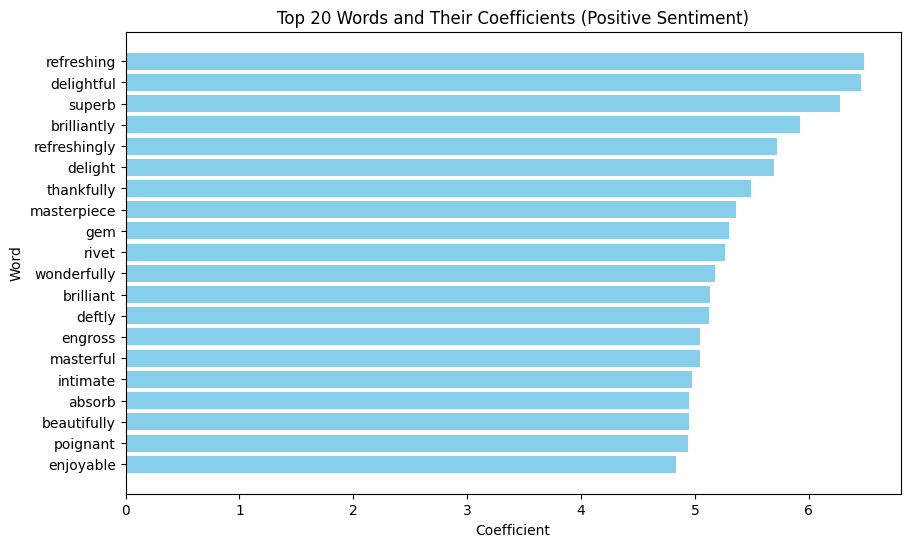

In [16]:
import matplotlib.pyplot as plt

significant_coef_df = significant_coef_df.sort_values(by='coefficient', ascending=False)

top_n = 20
top_words = significant_coef_df['word'].head(top_n)
top_coefficients = significant_coef_df['coefficient'].head(top_n)


plt.figure(figsize=(10, 6))
plt.barh(top_words, top_coefficients, color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.title(f'Top {top_n} Words and Their Coefficients (Positive Sentiment)')
plt.gca().invert_yaxis()
plt.show()


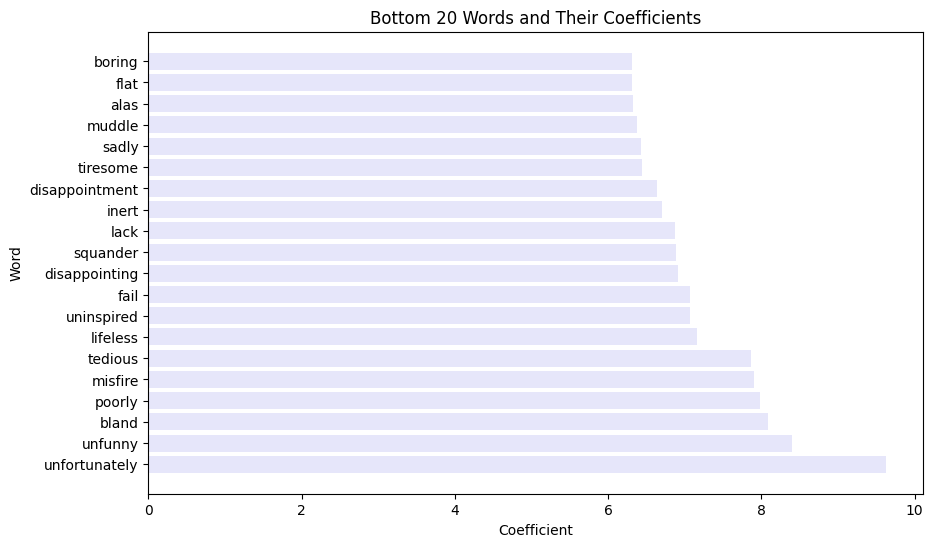

In [17]:
bottom_n = 20
bottom_words = significant_coef_df['word'].tail(bottom_n)
bottom_coefficients = significant_coef_df['abs_coefficient'].tail(bottom_n)

plt.figure(figsize=(10, 6))
plt.barh(bottom_words, bottom_coefficients, color='lavender')
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.title(f'Bottom {bottom_n} Words and Their Coefficients')
plt.gca().invert_yaxis()
plt.show()


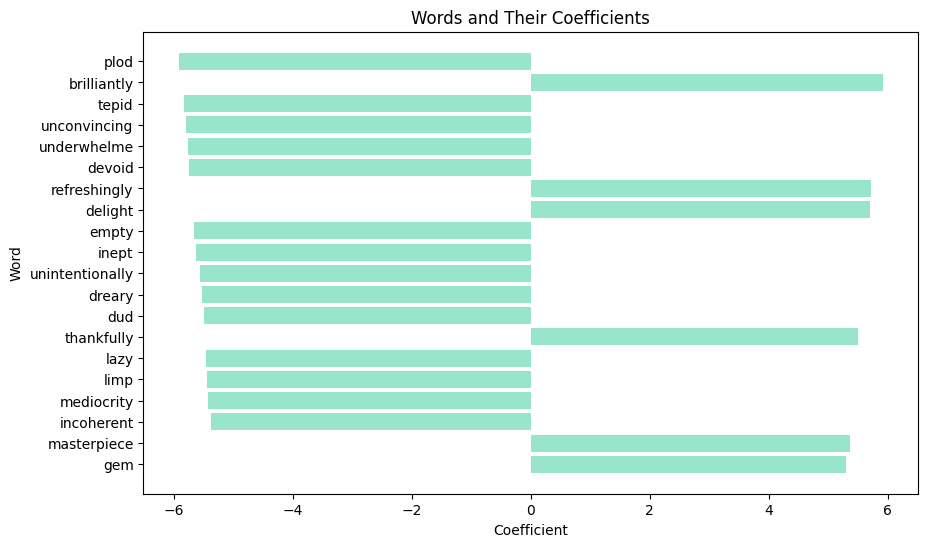

In [18]:
# Specify range of ABSOLUTE significant coefficient

min_coefficient = 2
max_coefficient = 6
filtered_df = significant_coef_df[(significant_coef_df['abs_coefficient'] >= min_coefficient) &
                                   (significant_coef_df['abs_coefficient'] <= max_coefficient)]

filtered_df = filtered_df.sort_values(by='abs_coefficient', ascending=False)

top_n = 20
top_words = filtered_df['word'].head(top_n)
top_coefficients = filtered_df['coefficient'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_words, top_coefficients, color=(0.2, 0.8, 0.6, 0.5))
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.title(f'Words and Their Coefficients')
plt.gca().invert_yaxis()
plt.show()


### Analysis
- Deprecatory texts are more strongly associated with negative sentiment reviews
- Appriciative and complimetary text are associated with positive sentiment reviews

# EDA 2 - Correlation of Quantitative Reviews
This section explores the correlation between reviewState, tomatoMeter, audienceScore, and scoreSentiment to understand the relationships between them.

## Visualizing EDA 2

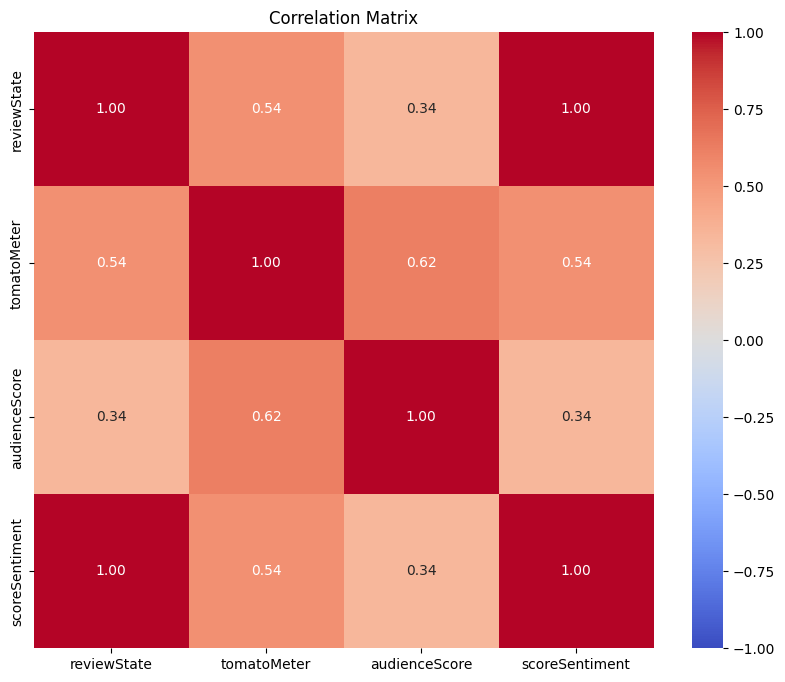

In [19]:
import seaborn as sns

selected_columns = ['reviewState', 'tomatoMeter', 'audienceScore', 'scoreSentiment']
correlation_matrix = train_df[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


### Analysis
- reviewStates, tomatoMater, audienceScore, and scoreSentiments all have moderate to strong positive correlation to each other. This highlights the consistency and of the reviews and ratings in the dataset

# EDA 3 - Genre Exploration and Analysis
This section explores the genres in the dataset and visualize the distribution of different genres by identify the most common ones.



## Data Manipulation

In [20]:
import pandas as pd

df_exploded_genres = train_df.copy()

df_exploded_genres['genre'] = df_exploded_genres['genre'].str.replace("[", "").str.replace("]", "").str.replace("'", "")
df_exploded_genres['genre'] = df_exploded_genres['genre'].apply(lambda x: x.split(', '))
df_exploded_genres = df_exploded_genres.explode('genre')

genre_counts = df_exploded_genres['genre'].value_counts()

genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Frequency']
genre_counts_df.to_csv('genre_counts.csv', index=False)

print(genre_counts)


genre
Drama                 323493
Comedy                202273
Mystery & thriller    155745
Action                116300
Adventure             109538
Horror                 70051
Fantasy                69078
Romance                63543
Documentary            63030
Sci-fi                 53606
Biography              43434
Crime                  41520
History                37741
Kids & family          37226
Animation              28591
Lgbtq+                 18351
Music                  15254
Musical                14347
War                    12664
Western                 7655
Holiday                 7401
Anime                   2950
Stand-up                 463
Sports & fitness         146
Sports                   116
Nature                    44
Short                     30
Foreign                   25
Special interest          18
Variety                    7
News                       4
Entertainment              4
Name: count, dtype: int64


## Visualizing EDA 3

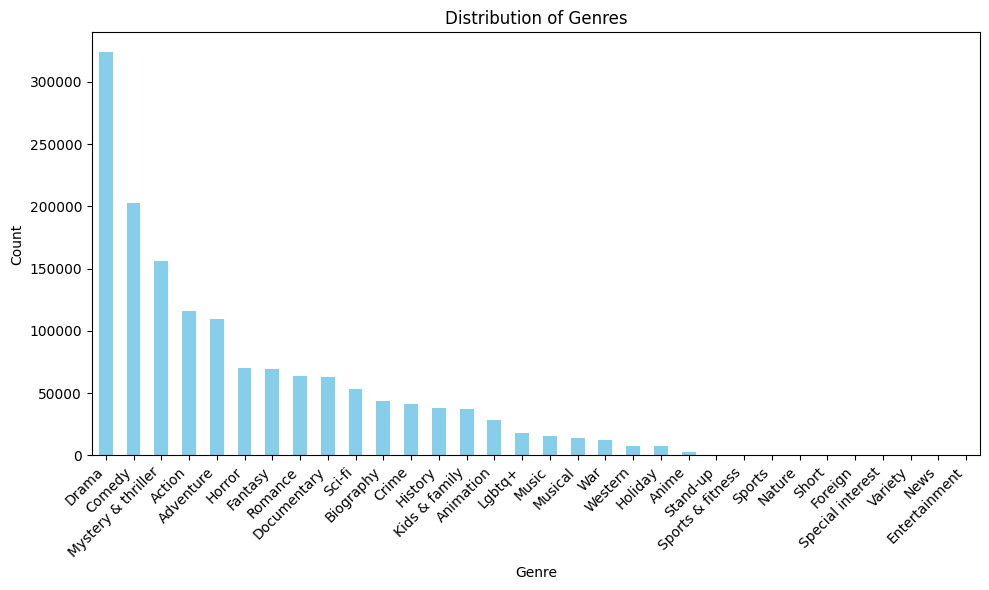

In [21]:
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

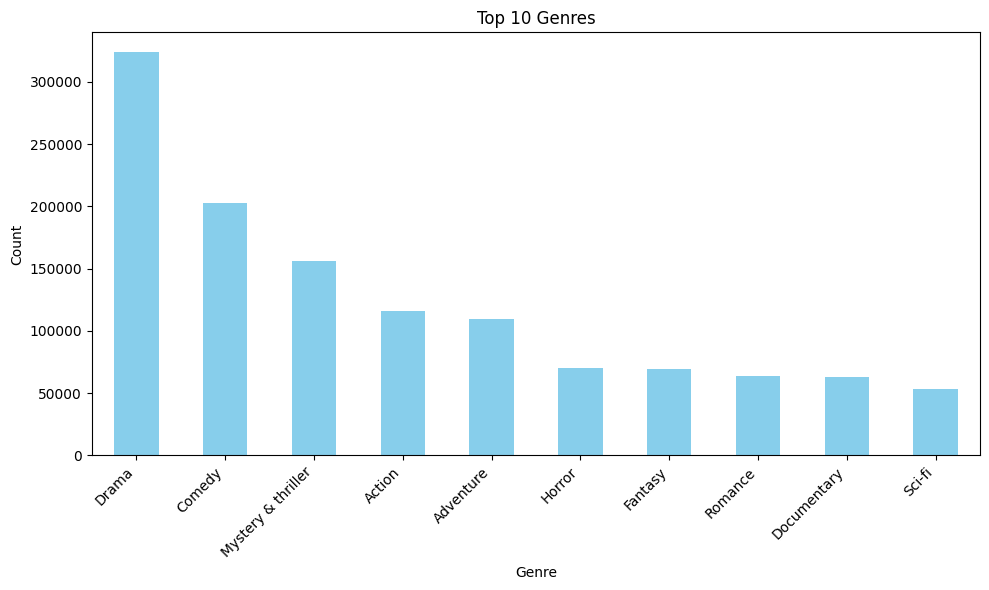

In [22]:
plt.figure(figsize=(10, 6))
top_20_genres = genre_counts.head(10)
top_20_genres.plot(kind='bar', color='skyblue')
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# EDA 4 - Exploration of Score Distribution
This section explores the distribution of reviews from top and regular critics, analyze if there is any difference in sentiment or ratings between reviews from each critics group.


## Visualizing EDA 4

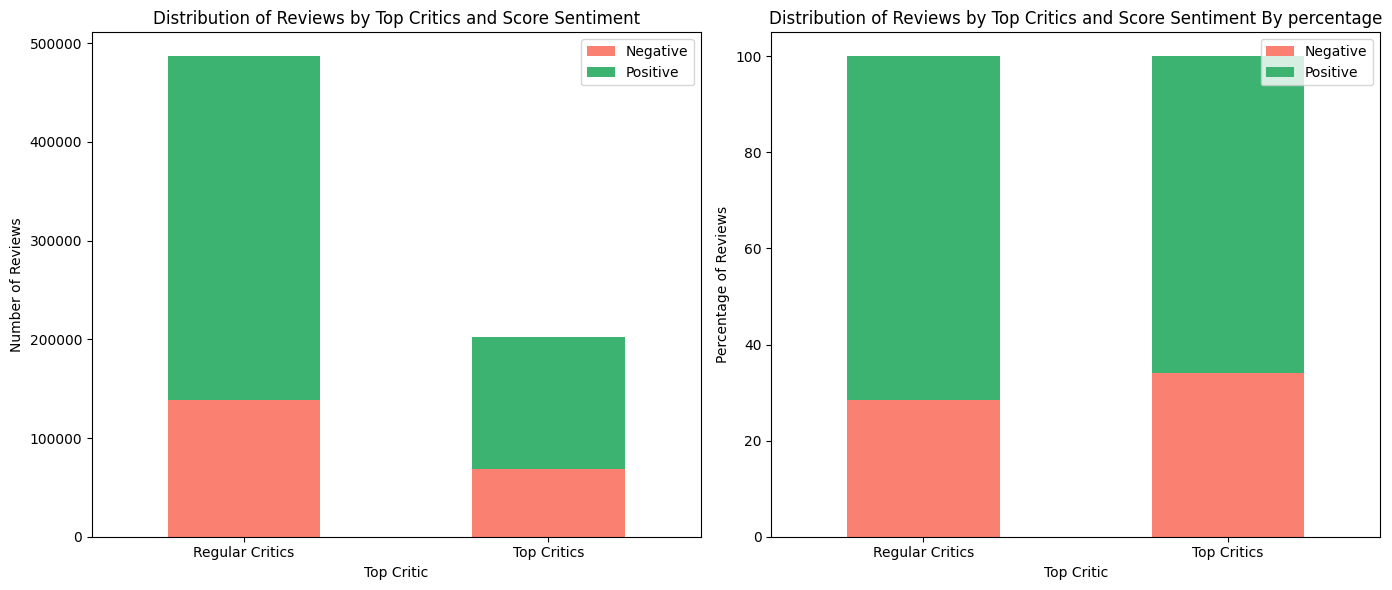

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Subplot - left
review_counts = train_df.groupby(['isTopCritic', 'scoreSentiment']).size().unstack()
ax = review_counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], ax=axs[0])
ax.set_title('Distribution of Reviews by Top Critics and Score Sentiment')
ax.set_xlabel('Top Critic')
ax.set_ylabel('Number of Reviews')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Regular Critics', 'Top Critics'], rotation=0)
ax.legend(['Negative', 'Positive'], loc='upper right')

# Subplot - right
total_reviews = review_counts.sum(axis=1)

percentage_negative = review_counts[0] / total_reviews * 100
percentage_positive = review_counts[1] / total_reviews * 100

ax = pd.concat([percentage_negative, percentage_positive], axis=1).plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], ax=axs[1])
ax.set_title('Distribution of Reviews by Top Critics and Score Sentiment By percentage')
ax.set_xlabel('Top Critic')
ax.set_ylabel('Percentage of Reviews')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Regular Critics', 'Top Critics'], rotation=0)
ax.legend(['Negative', 'Positive'], loc='upper right')

plt.tight_layout()
plt.show()


/var/folders/07/2p4bzdpn08555k79l69_78vm0000gn/T/ipykernel_52845/2790734157.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isTopCritic', y='tomatoMeter', data=df, palette=['lightsalmon', 'lightblue'])
/var/folders/07/2p4bzdpn08555k79l69_78vm0000gn/T/ipykernel_52845/2790734157.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isTopCritic', y='audienceScore', data=df, palette=['lightsalmon', 'lightblue'])


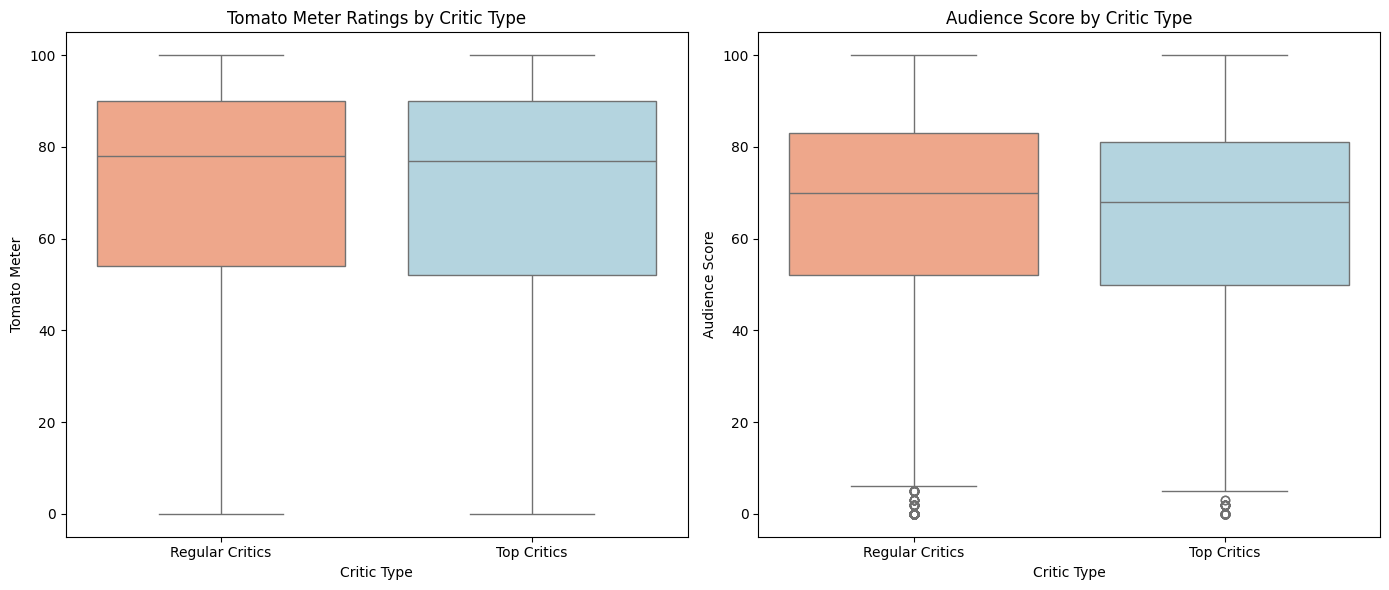

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Subplot - left
plt.subplot(1, 2, 1)
sns.boxplot(x='isTopCritic', y='tomatoMeter', data=df, palette=['lightsalmon', 'lightblue'])
plt.title('Tomato Meter Ratings by Critic Type')
plt.xlabel('Critic Type')
plt.ylabel('Tomato Meter')
plt.xticks(ticks=[0, 1], labels=['Regular Critics', 'Top Critics'])

# Subplot - right
plt.subplot(1, 2, 2)
sns.boxplot(x='isTopCritic', y='audienceScore', data=df, palette=['lightsalmon', 'lightblue'])
plt.title('Audience Score by Critic Type')
plt.xlabel('Critic Type')
plt.ylabel('Audience Score')
plt.xticks(ticks=[0, 1], labels=['Regular Critics', 'Top Critics'])


plt.tight_layout()
plt.show()


### Analysis
- Similar distributions can be seen between Regular Critics group and Top Critics group in terms of Score Sentiments, Tomato Meter Ratings, and Audience Score

# Hypothesis Testing

Word clouds for correctly and incorrectly classified reviews visually represent the most frequent words in these reviews, providing insights into the model’s behavior.

Insights
Word clouds help in identifying the most common words associated with correct and incorrect classifications.
They can reveal whether certain words are more likely to be associated with misclassifications.

In [25]:
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

## Hypothesis 1
### Null Hypothesis (H0): Words do not affect the sentiment score
### Alternative Hypothesis (HA): Words affect the sentiment score 

We hypothesize that specific keywords in movie reviews have a significant effect on the sentiment scores. To test this, we perform an independent t-test to compare the coefficients of keywords for positive and negative sentiments. The equal_var=False parameter indicates that we do not assume equal variances between the groups. Lastly, we compare the p-value from the t-test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating that specific keywords significantly affect the sentiment score.

In [26]:
hypo_test_1 = pd.read_csv('sig_coefficients.csv')

positive_scores = hypo_test_1[hypo_test_1['sentimentScore'] == 'POSITIVE']['coefficient']
negative_scores = hypo_test_1[hypo_test_1['sentimentScore'] == 'NEGATIVE']['coefficient']

t_statistic, p_value = ttest_ind(positive_scores, negative_scores, equal_var=False)

alpha = 0.05

print("p value: ")
print(p_value)

if p_value < alpha:
    print("Reject the null hypothesis: Specific keywords affect the sentiment score.")
else:
    print("Accept the null hypothesis: Specific keywords do not affect the sentiment score.")

p value: 
0.0
Reject the null hypothesis: Specific keywords affect the sentiment score.


## Hypothesis 2
### Null Hypothesis (H0): There is no significant relationship between scoreSentiment and genre.
### Alternative Hypothesis (HA): There is a significant relationship between scoreSentiment and genre 

We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

In [27]:
hypo_test_2 = pd.read_csv("final_2010_data_unknown.csv")

contingency_table = pd.crosstab(hypo_test_2['scoreSentiment'], hypo_test_2['genre'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05

print("p value: ")
print(p_value)

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between scoreSentiment and genre.")
else:
    print("Accept the null hypothesis: There is no significant relationship between scoreSentiment and genre.")

p value: 
0.0
Reject the null hypothesis: There is a significant relationship between scoreSentiment and genre.


## Hypothesis Testing 3
### Null Hypothesis (H0): There is no significant relationship between scoreSentiment and originalLanguage
### Alternative Hypothesis (HA): There is a significant relationship between scoreSentiment and originalLanguage 

We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

In [28]:
hypo_test_3 = pd.read_csv("final_2010_data_unknown.csv")

df_filtered = hypo_test_3[hypo_test_3['originalLanguage'] != 'unknown']

contingency_table = pd.crosstab(df_filtered['scoreSentiment'], df_filtered['originalLanguage'])

chi2, p, dof, ex = chi2_contingency(contingency_table)

alpha = 0.05

print("p value: ")
print(p_value)

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between scoreSentiment and originalLanguage.")
else:
    print("Accept the null hypothesis: There is no significant relationship between scoreSentiment and originalLanguage.")

p value: 
0.0
Reject the null hypothesis: There is a significant relationship between scoreSentiment and originalLanguage.


## Hypothesis Testing 4
### Null Hypothesis (H0): There is no significant relationship between scoreSentiment and isTopCritic
### Alternative Hypothesis (HA): There is a significant relationship between scoreSentiment and isTopCritic

We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

In [29]:
hypo_test_4 = pd.read_csv("final_2010_data_unknown.csv")

contingency_table = pd.crosstab(hypo_test_4['scoreSentiment'], hypo_test_4['isTopCritic'])

chi2, p, dof, ex = chi2_contingency(contingency_table)

alpha = 0.05

print("p value: ")
print(p_value)

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between scoreSentiment and isTopCritic.")
else:
    print("Accept the null hypothesis: There is no significant relationship between scoreSentiment and  isTopCritic.")

p value: 
0.0
Reject the null hypothesis: There is a significant relationship between scoreSentiment and isTopCritic.


We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

# Classification Model

We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

In [32]:
import numpy as np
from numpy import array
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

## Load and process data

In [33]:
movie_reviews = pd.read_csv('final_2010_data_0.csv', usecols=['reviewtext_cleaned', 'scoreSentiment'])
movie_reviews.head()

,scoreSentiment,reviewtext_cleaned
0,POSITIVE,choreography precise lifelike point one might ...
1,NEGATIVE,film outoftouch attempt humor may find hunt re...
2,POSITIVE,clumsy determination endear sometimes wildly e...
3,POSITIVE,every new minute there s another headscratchin...
4,POSITIVE,emotionless reaction shot zero characterizatio...


In [34]:
movie_reviews = movie_reviews.dropna()

movie_reviews['reviewtext_cleaned'] = movie_reviews['reviewtext_cleaned'].astype(str)

In [35]:
movie_reviews['scoreSentiment'] = movie_reviews['scoreSentiment'].replace(['POSITIVE', 'NEGATIVE'], [0, 1])
movie_reviews = movie_reviews.infer_objects(copy=False)

movie_reviews.head()

/var/folders/07/2p4bzdpn08555k79l69_78vm0000gn/T/ipykernel_52845/3076547075.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movie_reviews['scoreSentiment'] = movie_reviews['scoreSentiment'].replace(['POSITIVE', 'NEGATIVE'], [0, 1])


,scoreSentiment,reviewtext_cleaned
0,0,choreography precise lifelike point one might ...
1,1,film outoftouch attempt humor may find hunt re...
2,0,clumsy determination endear sometimes wildly e...
3,0,every new minute there s another headscratchin...
4,0,emotionless reaction shot zero characterizatio...


## Split data

We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

In [36]:
movie_reviews = movie_reviews[:50000]

X = movie_reviews['reviewtext_cleaned']
y = movie_reviews['scoreSentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((40000,), (10000,))

## Download NLTK stopwords

In [ ]:
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

## Build and train model

We hypothesize that there is a significant relationship between the sentiment score of a review and the genre of the movie. We use the chi-square test of independence to test this hypothesis. Then, we compare the p-value from the chi-square test with our significance level (alpha). If the p-value is less than 0.05, we reject the null hypothesis, indicating a significant relationship between sentiment score and genre.

In [38]:
model = Pipeline([('vectorizer', CountVectorizer(stop_words=nltk_stopwords)), ('rf', RandomForestClassifier(random_state=2))])
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestClassifier(random_state=2))])

## Hyperparameter tuning - Grid search

The hyperparameters tuned include:

Number of estimators (trees in the forest)
Maximum depth of the trees
Maximum number of features used for splitting

In [39]:
param_grid = {
    'vectorizer__max_features': [1000, 2000, 3000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20]
}

In [40]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1); total time=  35.9s
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1); total time=  39.8s
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 1); total time=  42.3s
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 2); total time=  48.1s
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2); total time= 1.2min
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1); total time= 1.3min
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 1); total time= 1.4min
[CV] EN

/opt/miniconda3/envs/wif3009/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1); total time=  35.9s
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2); total time=  36.8s
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2); total time=  40.3s
[CV] END rf__max_depth=None, rf__n_estimators=100, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 1); total time=  46.4s
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1); total time= 1.2min
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1); total time= 1.3min
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2); total time= 1.3min
[CV] END rf__max_depth=None, rf__n_estimators=200, vectorizer__max_fe

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('rf',
                                        RandomForestClassifier(random_state=2))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__n_estimators': [100, 200, 300],
                         'vectorizer__max_features': [1000, 2000, 3000],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=2)

[CV] END rf__max_depth=None, rf__n_estimators=300, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 2); total time= 2.3min
[CV] END rf__max_depth=10, rf__n_estimators=200, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 2); total time=   6.3s
[CV] END rf__max_depth=10, rf__n_estimators=300, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1); total time=   6.0s
[CV] END rf__max_depth=10, rf__n_estimators=300, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1); total time=   5.4s
[CV] END rf__max_depth=10, rf__n_estimators=300, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1); total time=   5.3s
[CV] END rf__max_depth=10, rf__n_estimators=300, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2); total time=   7.4s
[CV] END rf__max_depth=10, rf__n_estimators=300, vectorizer__max_features=3000, vectorizer__ngram_range=(1, 2); total time=   7.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, vectorizer__max_features=1000, v

## Insights from the metrics

### Model performance metrics

The model performance metrics provide a quantitative evaluation of how well our classification model performs. Key metrics include precision, recall, and F1-score for each class (positive and negative reviews) as well as overall accuracy.

- Precision: Indicates the percentage of positive predictions that were actually correct. High precision means fewer false positives.
- Recall: Indicates the percentage of actual positives that were correctly identified by the model. High recall means fewer false negatives.
- F1-Score: The harmonic mean of precision and recall, providing a balance between the two.
- Accuracy: The overall percentage of correctly classified reviews.

In [41]:
y_predicted = grid_search.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      7014
           1       0.62      0.48      0.55      2986

    accuracy                           0.76     10000
   macro avg       0.71      0.68      0.69     10000
weighted avg       0.75      0.76      0.75     10000



In [44]:
print("Insights")
print(f"Accuracy: {np.mean(y_predicted == y_test):.2f}")
print(f"Precision for class 0 (Positive): {classification_report(y_test, y_predicted, output_dict=True)['0']['precision']:.2f}")
print(f"Recall for class 0 (Positive): {classification_report(y_test, y_predicted, output_dict=True)['0']['recall']:.2f}")
print(f"F1-score for class 0 (Positive): {classification_report(y_test, y_predicted, output_dict=True)['0']['f1-score']:.2f}")
print(f"Precision for class 1 (Negative): {classification_report(y_test, y_predicted, output_dict=True)['1']['precision']:.2f}")
print(f"Recall for class 1 (Negative): {classification_report(y_test, y_predicted, output_dict=True)['1']['recall']:.2f}")
print(f"F1-score for class 1 (Negative): {classification_report(y_test, y_predicted, output_dict=True)['1']['f1-score']:.2f}")

Insights
Accuracy: 0.76
Precision for class 0 (Positive): 0.80
Recall for class 0 (Positive): 0.87
F1-score for class 0 (Positive): 0.84
Precision for class 1 (Negative): 0.62
Recall for class 1 (Negative): 0.48
F1-score for class 1 (Negative): 0.55


### Confusion matrix

A confusion matrix is a table that summarizes the performance of a classification model by showing the number of correct and incorrect predictions for each class.

- True Positives (TP): Correctly classified positive reviews.
- True Negatives (TN): Correctly classified negative reviews.
- False Positives (FP): Negative reviews incorrectly classified as positive.
- False Negatives (FN): Positive reviews incorrectly classified as negative.

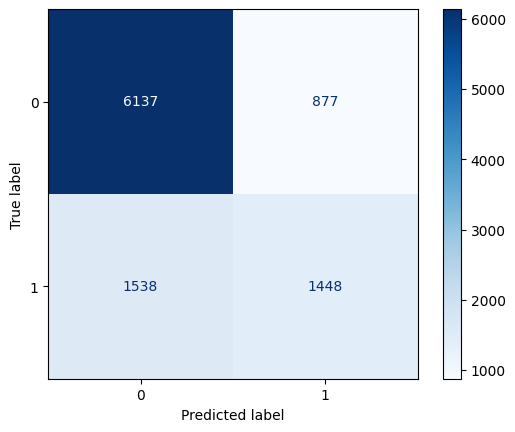

In [42]:
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.show()

### Bar charts that show the number of correctly and incorrectly classified reviews

Bar charts can visually represent the number of correctly and incorrectly classified reviews for both positive and negative sentiments.

- The bar chart helps to quickly identify the model's strengths and weaknesses in classification.
- It shows the distribution of correct and incorrect predictions for each sentiment class.

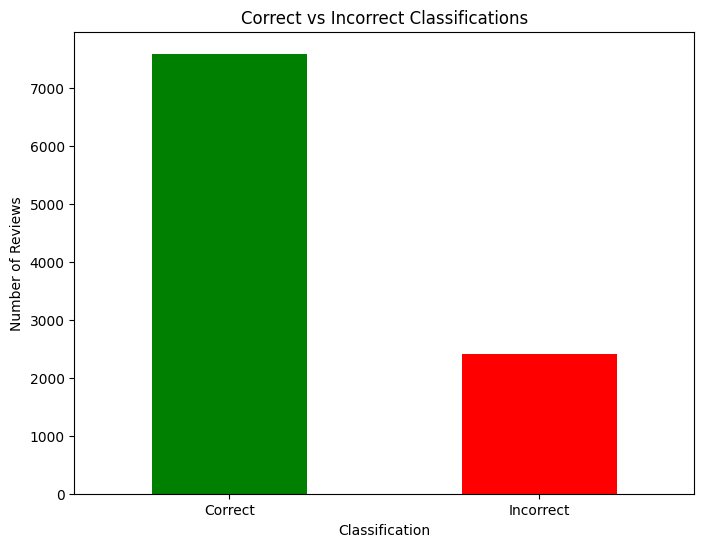

In [66]:
import matplotlib.pyplot as plt

correct_counts = df['Correct'].value_counts()

plt.figure(figsize=(8, 6))
correct_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Correct vs Incorrect Classifications')
plt.xlabel('Classification')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['Correct', 'Incorrect'], rotation=0)
plt.show()

### Examples of correctly classified reviews

Displaying examples of correctly classified reviews helps to qualitatively assess the model’s performance.

- These examples provide context and help validate the model's effectiveness in identifying positive and negative sentiments.
- Reviewing these examples helps to understand what features or keywords the model might be leveraging.

In [53]:
import pandas as pd

test_data = pd.DataFrame({'Review': X_test, 'Actual': y_test, 'Predicted': y_predicted})

label_mapping = {0: 'Positive', 1: 'Negative'}

correctly_classified = test_data[test_data['Actual'] == test_data['Predicted']].head(5)

for _, row in correctly_classified.iterrows():
    review = row['Review']
    predicted_label = label_mapping[row['Predicted']]
    actual_label = label_mapping[row['Actual']]
    print(f"Review: {review}\nPredicted: {predicted_label}, Actual: {actual_label}\n")

Review: hillcoat capture roughandtumble bondurant bootleg existence violence erupt intersection money vice thrill jack rise hotshot junior mobster
Predicted: Positive, Actual: Positive

Review: merge catholic hagiography portuguese folklore personal journey rodrigue present liltingly lyrical always demand tract bear imprint luis buuel apichatpong weerasethakul
Predicted: Positive, Actual: Positive

Review: story familiar one vintage clip great like alice cooper you ll love
Predicted: Positive, Actual: Positive

Review: child actor excellent always madhab film old lot whose performance effortful especially callingattentiontoitselfpart mishra capable much subtlety
Predicted: Positive, Actual: Positive

Review: beautifully shoot pontutis adaptation stay faithful original story increasingly intrusive score claustrophobic frame yellow wallpaper help audience feel jane really feel
Predicted: Positive, Actual: Positive



### Examples of incorrectly classified reviews


Displaying examples of incorrectly classified reviews helps to identify the types of errors the model is making.

- These examples highlight potential areas where the model is confused, providing opportunities for improvement.
- They help to understand whether certain keywords or phrases are causing misclassifications.

In [54]:
import pandas as pd

test_data = pd.DataFrame({'Review': X_test, 'Actual': y_test, 'Predicted': y_predicted})

label_mapping = {0: 'Positive', 1: 'Negative'}

incorrectly_classified = test_data[test_data['Actual'] != test_data['Predicted']].head(5)

for _, row in incorrectly_classified.iterrows():
    review = row['Review']
    predicted_label = label_mapping[row['Predicted']]
    actual_label = label_mapping[row['Actual']]
    print(f"Review: {review}\nPredicted: {predicted_label}, Actual: {actual_label}\n")

Review: perhaps radical break elusive entity come label gay sensibility maybe attempt redefine
Predicted: Negative, Actual: Positive

Review: dune ripe cult adoration
Predicted: Negative, Actual: Positive

Review: someone bind create mashup film effect sequence cool halfhour highlight package ultimately become good way watch
Predicted: Positive, Actual: Negative

Review: putative sequel different every way shortandsweet genreblurre grossout freakout allout comedy switch original gender utterly lower tone
Predicted: Negative, Actual: Positive

Review: film do not convey either tragedy response way hidebound documentary convention
Predicted: Positive, Actual: Negative



### List of classified reviews

In [68]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.8 MB/s eta 0:00:0000:0100:01


In [69]:
import ipywidgets as widgets
from IPython.display import display

correct_widget = widgets.Dropdown(
    options=['All', 'Correct', 'Incorrect'],
    value='All',
    description='Correctness:'
)

sentiment_widget = widgets.Dropdown(
    options=['All', 'Positive', 'Negative'],
    value='All',
    description='Sentiment:'
)

def filter_reviews(correctness, sentiment):
    filtered_df = df.copy()
    if correctness != 'All':
        correct_value = True if correctness == 'Correct' else False
        filtered_df = filtered_df[filtered_df['Correct'] == correct_value]
    if sentiment != 'All':
        filtered_df = filtered_df[filtered_df['Actual'] == sentiment]
    
    for idx, row in filtered_df.iterrows():
        color = 'green' if row['Correct'] else 'red'
        display(HTML(f"<p style='color:{color};'>Review: {row['Review']}<br>Predicted: {row['Predicted']}, Actual: {row['Actual']}</p>"))

output = widgets.interactive_output(filter_reviews, {
    'correctness': correct_widget,
    'sentiment': sentiment_widget
})

display(correct_widget, sentiment_widget, output)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Dropdown(description='Correctness:', options=('All', 'Correct', 'Incorrect'), value='All')

Dropdown(description='Sentiment:', options=('All', 'Positive', 'Negative'), value='All')

Output()

### Bar Charts for precision, recall, and F1-score

Bar charts can visualize precision, recall, and F1-score for both positive and negative sentiments, making it easy to compare these metrics across classes.

- These charts highlight the differences in performance between classes.
- They help in understanding which metric needs improvement.

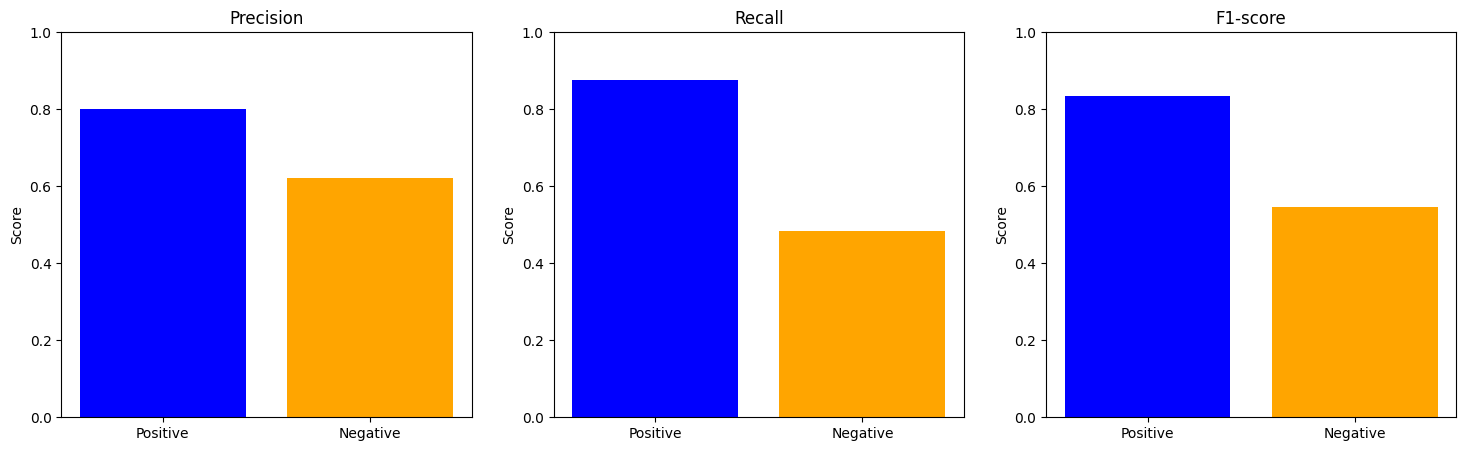

In [57]:
report = classification_report(y_test, y_predicted, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

data = {metric: [report[cls][metric] for cls in classes] for metric in metrics}

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(metrics):
    ax[i].bar(classes, data[metric], color=['blue', 'orange'])
    ax[i].set_title(metric.capitalize())
    ax[i].set_ylim(0, 1)
    ax[i].set_xticks(range(len(classes)))
    ax[i].set_xticklabels(['Positive', 'Negative'])
    ax[i].set_ylabel('Score')
plt.show()

### Word clouds for correct and incorrect classifications

Word clouds for correctly and incorrectly classified reviews visually represent the most frequent words in these reviews, providing insights into the model’s behavior.

- Word clouds help in identifying the most common words associated with correct and incorrect classifications.
- They can reveal whether certain words are more likely to be associated with misclassifications.

In [60]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.8 MB/s eta 0:00:00a 0:00:01


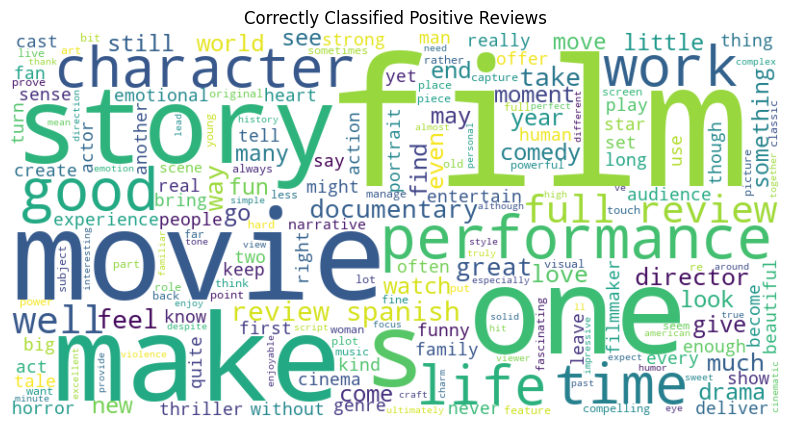

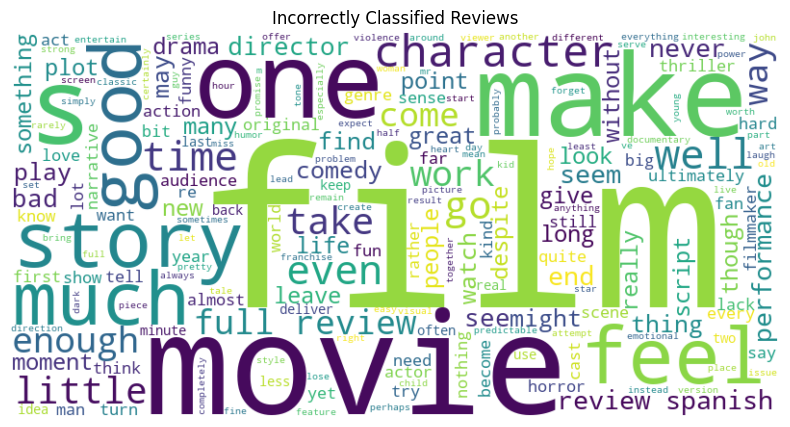

In [61]:
from wordcloud import WordCloud

correctly_classified_pos = X_test[(y_test == y_predicted) & (y_test == 0)]
incorrectly_classified = X_test[(y_test != y_predicted)]

def generate_word_cloud(text_data, title):
    text = ' '.join(text_data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_word_cloud(correctly_classified_pos, 'Correctly Classified Positive Reviews')

generate_word_cloud(incorrectly_classified, 'Incorrectly Classified Reviews')